<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Autoencoder_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Efficient Autoencoder**

## By **Vinay Kumar Thakur**
### M.Tech. (IIT Kanpur), B.Tech. (NITK Surathkal)

Designed Autoencoder using Inception, Depthwiae Convolutions, Residual COnnection, Laplacian of Gaussian Filters, Unet, Attention and Custom Pooling. It reduces the parameters drastically.   

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [3]:
@tf.keras.utils.register_keras_serializable()
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(ResidualLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])

        conv_block = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer([None, None, in_channel]),
            tf.keras.layers.DepthwiseConv2D(kernel_size = (3, 3), padding = 'same', use_bias = False),
            tf.keras.layers.DepthwiseConv2D(kernel_size = (3, 3), padding = 'same', use_bias = False),
        ]) 
            
        
        gaussian = np.array([
            [1, 2, 1],
            [2, 4, 2],
            [1, 2, 1]
        ]) / 16

        laplacian = np.array([
            [0,  1, 0],
            [1, -4, 1],
            [0,  1, 0]
        ]) / 8

        gaussian = np.stack([gaussian] * in_channel, axis = -1)
        laplacian = np.stack([laplacian] * in_channel, axis = -1)

        gaussian = gaussian[..., np.newaxis]
        laplacian = laplacian[..., np.newaxis]

        conv_block.set_weights([gaussian, laplacian])
        conv_block.trainable = False

        ff_net = tf.keras.models.Sequential([
            tf.keras.layers.Dense(in_channel), 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),  
        ])

        x = inp
        x = conv_block(x)
        x = ff_net(x)
        x = tf.keras.layers.Add()([x, inp])
        x = tf.keras.layers.LayerNormalization()(x)

        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(ResidualLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [4]:
@tf.keras.utils.register_keras_serializable()
class DownPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(DownPoolingLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]

        inp = tf.keras.layers.Input(input_shape[1:])
        conv = tf.keras.layers.Conv2D(2, kernel_size = (2, 2), strides = (2, 2), padding = 'valid')

        x = inp 
        x = tf.keras.layers.Lambda(lambda t : tf.split(t, num_or_size_splits = in_channel, axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(DownPoolingLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [5]:
@tf.keras.utils.register_keras_serializable()
class UpPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwds):
        super(UpPoolingLayer, self).__init__(*args, **kwds)

    def build(self, input_shape):
        in_channel = input_shape[-1]
        out_channel = int(in_channel/2)

        inp = tf.keras.layers.Input(input_shape[1:])
        conv = tf.keras.layers.Conv2DTranspose(1, kernel_size = (2, 2), strides = (2, 2), padding = 'valid')

        x = inp 
        x = tf.keras.layers.Lambda(lambda t : tf.split(t, num_or_size_splits = out_channel, axis = -1))(x)
        x = tf.keras.layers.Concatenate(axis = -1)([conv(t) for t in x])
        out = x

        self.layer_block = tf.keras.models.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.layer_block(input)

    def get_config(self):
        config = super(UpPoolingLayer, self).get_config()
        config.update({
            "layer_block": self.layer_block,
        })

        return config

    @classmethod
    def from_config(cls, **config):
        return cls(**config)

In [6]:
def get_dataset():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar100.load_data()

    train_x = train_x / 127.5 - 1

    return train_x, train_y 

In [7]:
def u_net():
    inp = tf.keras.layers.Input([32, 32, 3])

    x = inp

    x0 = x

    x = DownPoolingLayer()(x) 

    x = ResidualLayer()(x)
    x1 = x # 16 x 16

    x = DownPoolingLayer()(x)

    x = ResidualLayer()(x)
    x2 = x # 8 x 8

    x = DownPoolingLayer()(x)

    x = ResidualLayer()(x)
    x3 = x # 4 x 4

    x = DownPoolingLayer()(x)

    x = ResidualLayer()(x)
    x4 = x # 2 x 2

    x = DownPoolingLayer()(x)
    encodings = x # 1 x 1
    x = UpPoolingLayer()(x)

    value = tf.keras.layers.Reshape([2 * 2, -1])(x)
    query = tf.keras.layers.Reshape([2 * 2, -1])(x4)
    x = tf.keras.layers.Attention(use_scale = True)([query, value]) # 2 x 2
    x = tf.keras.layers.Reshape([2, 2, -1])(x)

    x = UpPoolingLayer()(x)

    value = tf.keras.layers.Reshape([4 * 4, -1])(x)
    query = tf.keras.layers.Reshape([4 * 4, -1])(x3)
    x = tf.keras.layers.Attention(use_scale = True)([query, value]) # 4 x 4
    x = tf.keras.layers.Reshape([4, 4, -1])(x)

    x = UpPoolingLayer()(x)

    value = tf.keras.layers.Reshape([8 * 8, -1])(x)
    query = tf.keras.layers.Reshape([8 * 8, -1])(x2)
    x = tf.keras.layers.Attention(use_scale = True)([query, value]) # 8 x 8
    x = tf.keras.layers.Reshape([8, 8, -1])(x)

    x = UpPoolingLayer()(x)

    value = tf.keras.layers.Reshape([16 * 16, -1])(x)
    query = tf.keras.layers.Reshape([16 * 16, -1])(x1)
    x = tf.keras.layers.Attention(use_scale = True)([query, value]) # 16 x 16
    x = tf.keras.layers.Reshape([16, 16, -1])(x)

    x = UpPoolingLayer()(x)

    value = tf.keras.layers.Reshape([32 * 32, -1])(x)
    query = tf.keras.layers.Reshape([32 * 32, -1])(x0)
    x = tf.keras.layers.Attention(use_scale = True)([query, value]) # 32 x 32
    x = tf.keras.layers.Reshape([32, 32, -1])(x)

    x = tf.keras.layers.Dense(3, activation = 'tanh')(x)
    
    out = x

    model = tf.keras.models.Model(inputs = [inp], outputs = [out])
    encoder_model = tf.keras.models.Model(inputs = [inp], outputs = [encodings])

    return  model, encoder_model 

In [8]:
model, encoder = u_net()
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 down_pooling_layer (DownPoo  (None, 16, 16, 6)        10        
 lingLayer)                                                      
                                                                 
 residual_layer (ResidualLay  (None, 16, 16, 6)        186       
 er)                                                             
                                                                 
 down_pooling_layer_1 (DownP  (None, 8, 8, 12)         10        
 oolingLayer)                                                    
                                                                 
 residual_layer_1 (ResidualL  (None, 8, 8, 12)         444       
 ayer)                                                     

In [9]:
train_x, train_y = get_dataset()

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_absolute_error',
    metrics = ['mean_absolute_error', 'mean_squared_error']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 down_pooling_layer (DownPoolin  (None, 16, 16, 6)   10          ['input_1[0][0]']                
 gLayer)                                                                                          
                                                                                                  
 residual_layer (ResidualLayer)  (None, 16, 16, 6)   186         ['down_pooling_layer[0][0]']     
                                                                                                  
 down_pooling_layer_1 (DownPool  (None, 8, 8, 12)    10          ['residual_layer[0][0]']     

In [11]:
model.fit(x = train_x, y = train_x, epochs = 1, batch_size = 8, shuffle = True)

6250/6250 [==============================] - 1413s 225ms/step - loss: 0.1154 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0324


In [12]:
x = train_x[:50]
y = model.predict(x)

z = np.concatenate([x, y], axis = 2)

img_arr = np.uint8(np.floor(127.5 * (z + 1) + 0.5))

2/2 [==============================] - 2s 102ms/step


In [13]:
img_arr.shape

(50, 32, 64, 3)

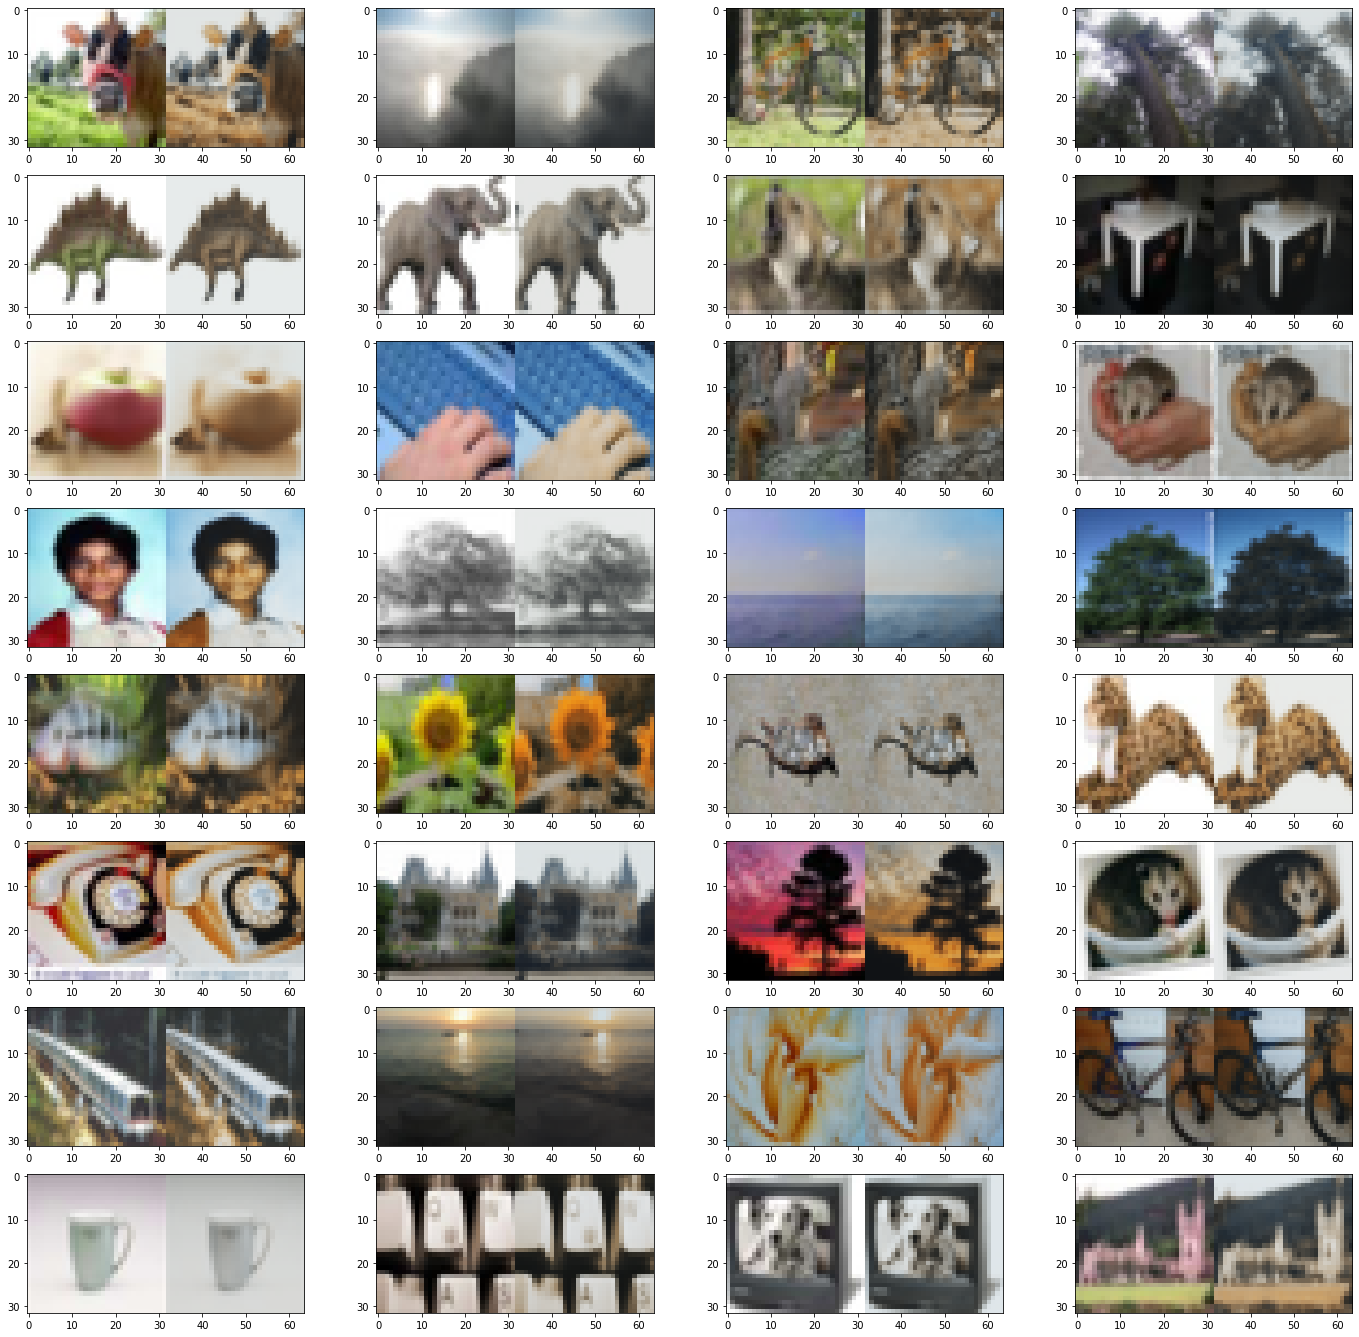

In [14]:
fig, axes = plt.subplots(8, 4, figsize = (24, 24))

for idx, row in enumerate(axes):
    for jdx, ax in enumerate(row):
        ax.imshow(img_arr[idx + 8 * jdx])


In [15]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 down_pooling_layer (DownPoo  (None, 16, 16, 6)        10        
 lingLayer)                                                      
                                                                 
 residual_layer (ResidualLay  (None, 16, 16, 6)        186       
 er)                                                             
                                                                 
 down_pooling_layer_1 (DownP  (None, 8, 8, 12)         10        
 oolingLayer)                                                    
                                                                 
 residual_layer_1 (ResidualL  (None, 8, 8, 12)         444       
 ayer)                                                     

In [16]:
encoder.save('encoding_model')

In [17]:
!zip -r encoding_model.zip encoding_model

updating: encoding_model/ (stored 0%)
updating: encoding_model/keras_metadata.pb (deflated 96%)
updating: encoding_model/assets/ (stored 0%)
updating: encoding_model/saved_model.pb (deflated 91%)
updating: encoding_model/variables/ (stored 0%)
updating: encoding_model/variables/variables.index (deflated 67%)
updating: encoding_model/variables/variables.data-00000-of-00001 (deflated 68%)


In [18]:
gcf.download('encoding_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>